In [11]:
import numpy as np
import scipy.stats as scs
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from tqdm import tqdm
plt.rcParams.update({'font.size': 30})

# Copula estimation with Scoring Rules

### Creating locations

C:\Users\david\AppData\Local\Temp\ipykernel_18232\3841449686.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


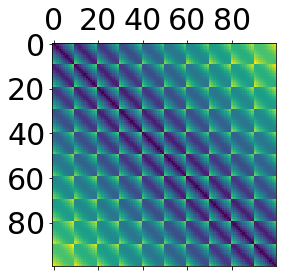

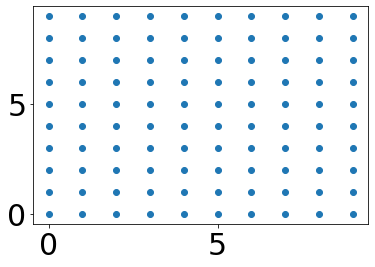

In [13]:
# define x and y ranges and step size
x_range = np.arange(0, 10, step=1)
y_range = np.arange(0, 10, step=1)

# create grid of 2D locations using meshgrid function
xx, yy = np.meshgrid(x_range, y_range)
locations = np.column_stack((xx.ravel(), yy.ravel()))

# create distance matrix
dist_mat = distance_matrix(locations,locations)
plt.matshow(dist_mat)
plt.tight_layout()
plt.show()
plt.scatter(locations[:,0],locations[:,1])

### Generating observations for locations

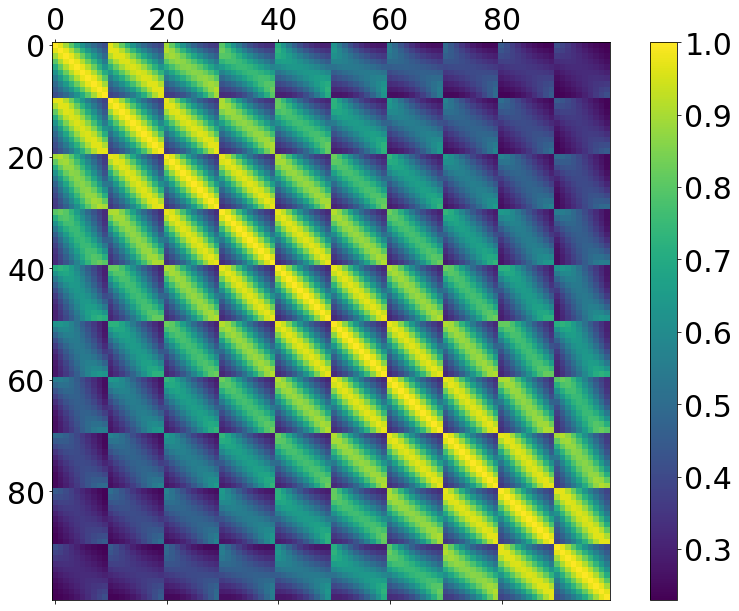

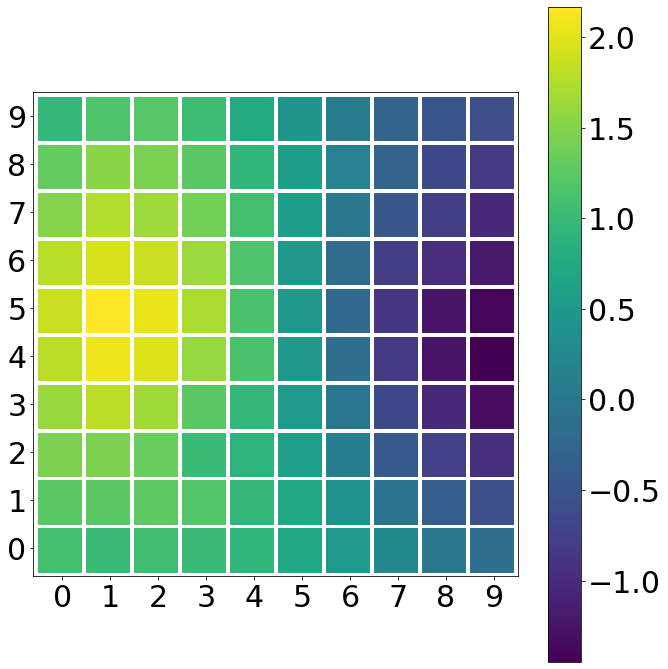

In [46]:
# covariance matrix
true_theta = [33,3]
plt.matshow(Matern(length_scale=true_theta[0], nu=true_theta[1]).__call__(dist_mat))
plt.colorbar()
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.show()

# generate samples
true_cov = Matern(length_scale=true_theta[0], nu=true_theta[1]).__call__(dist_mat)
obs = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=true_cov, size=1000)

# create plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xticks(x_range)
ax.set_yticks(y_range)

# define colormap
cmap = plt.cm.get_cmap('viridis')

# plot locations as colored rectangles
for i, loc in enumerate(locations):
    x, y = loc
    color = cmap((obs[0, i] - obs[0].min()) / (obs[0].max() - obs[0].min()))
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 0.9, 0.9, fill=True, color=color))

# add colorbar
norm = plt.Normalize(vmin=obs[0].min(), vmax=obs[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)

plt.xlim(-0.6,9.5)
plt.ylim(-0.6,9.5)
plt.tight_layout()
plt.show()

### Scoring Rule

In [4]:
from scipy.spatial.distance import pdist

def Spatial_Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy

def SR_eval(theta,beta,obs,D):
    sims = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=Matern(length_scale=theta[0], nu=theta[1]).__call__(D), size=1000)
    out = 0
    for row in tqdm(obs):
        out+= Spatial_Energy_Score(beta,row,sims)
    return out/len(obs)

In [5]:
SR_eval([33,33],1,obs[:500],dist_mat)

100%|██████████| 500/500 [00:16<00:00, 30.62it/s]


13.061720947532436

In [6]:
'''t = []
for k in range(1,50):
    t.append(SR_eval([k,33],0.2,obs,dist_mat))

# save
import pickle
with open('SR_values.txt','wb') as f:
    pickle.dump(t,f)'''

# load
import pickle
with open('SR_values.txt','rb') as f:
    t = pickle.load(f)

In [27]:
(np.argmin(t),np.min(t))

(29, 1.6527999608761952)

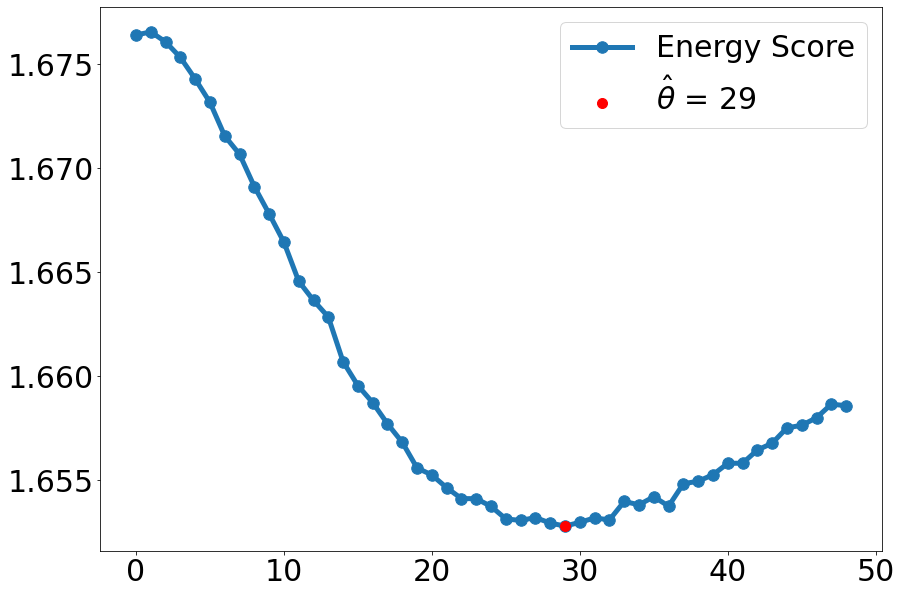

In [36]:
plt.plot(t,marker='.',linewidth=5,markersize=23,label='Energy Score') # beta=0.2
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.scatter(np.argmin(t),np.min(t),c='red',s=100,zorder=10,label='$\hat{\\theta}$ = '+str(np.argmin(t)))
plt.legend()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_18232\344109949.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


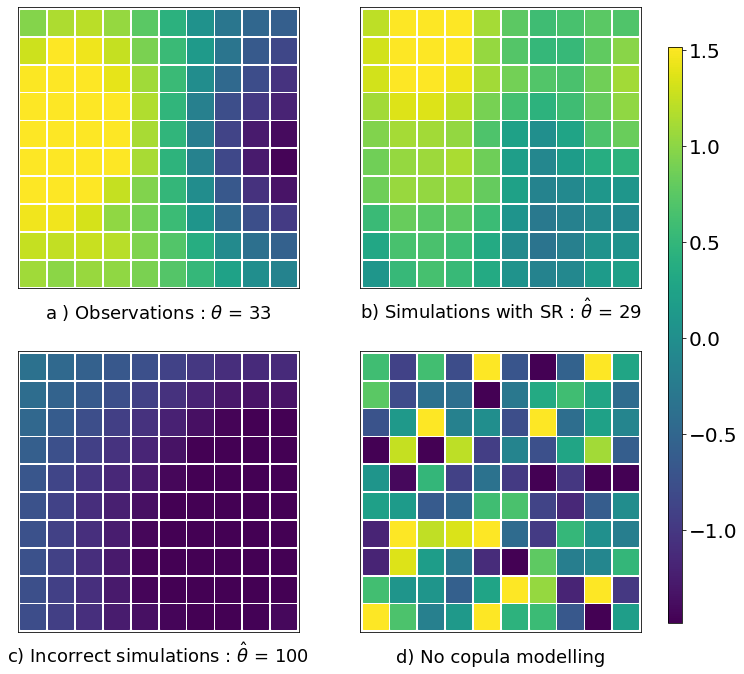

In [119]:
# define colormap
cmap = plt.cm.get_cmap('viridis')

# simulations
sample1 = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=Matern(length_scale=29, nu=3).__call__(dist_mat), size=1)
sample2 = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=Matern(length_scale=100, nu=3).__call__(dist_mat), size=1)
sample3 = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=np.eye(100), size=1)
# set normalization for color scale
vmin = 0.7*min(obs[0].min(),sample1.min(),sample2.min(),sample3.min())
vmax = 0.7*max(obs[0].max(),sample1.max(),sample2.max(),sample3.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# create subplots
titles = ['a ) Observations : $\\theta$ = 33','b) Simulations with SR : $\hat{\\theta}$ = 29','c) Incorrect simulations : $\hat{\\theta}$ = 100','d) No copula modelling']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    # plot locations as colored rectangles for each array
    if i == 0:
        sample = obs[0]
    elif i == 1:
        sample = sample1
    elif i == 2:
        sample = sample2
    else:
        sample = sample3
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    for j, loc in enumerate(locations):
        color = cmap(norm(sample[j]))
        x, y = loc
        ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 0.9, 0.9, fill=True, color=color))
    # set limits and title for each subplot, and increase font size
    ax.set_xlim(-0.6, 9.5)
    ax.set_ylim(-0.6, 9.5)
    ax.set_title(titles[i], fontsize=18, y=-0.13)

# create colorbar on the right
cax = fig.add_axes([0.97, 0.1, 0.02, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()